In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from src.knn import KNNClassifier

import matplotlib.pyplot as plt

In [2]:
rs = np.random.RandomState(12)

# Filter out user warnings related to the tokenizer
os.environ["PYTHONWARNINGS"] = "ignore"

## Data

In [3]:
# Subset of 20 newsgroups dataset
categories = ["soc.religion.christian", "comp.graphics", "sci.med"]

twenty_train = fetch_20newsgroups(
    subset="train", categories=categories, shuffle=True, random_state=rs
)

len(twenty_train.data)

1777

### Features

In [4]:
for i in range(3):
    print("\n".join(twenty_train.data[i].split("\n")[:3]), "\n")

From: kene@acs.bu.edu (Kenneth Engel)
Subject: Re: Atheists and Hell
Organization: Boston University, Boston, MA, USA 

From: ab@nova.cc.purdue.edu (Allen B)
Subject: Re: TIFF: philosophical significance of 42
Organization: Purdue University 

From: grante@aquarius.rosemount.com (Grant Edwards)
Subject: Re: Krillean Photography
Reply-To: grante@aquarius.rosemount.com (Grant Edwards) 



### Target

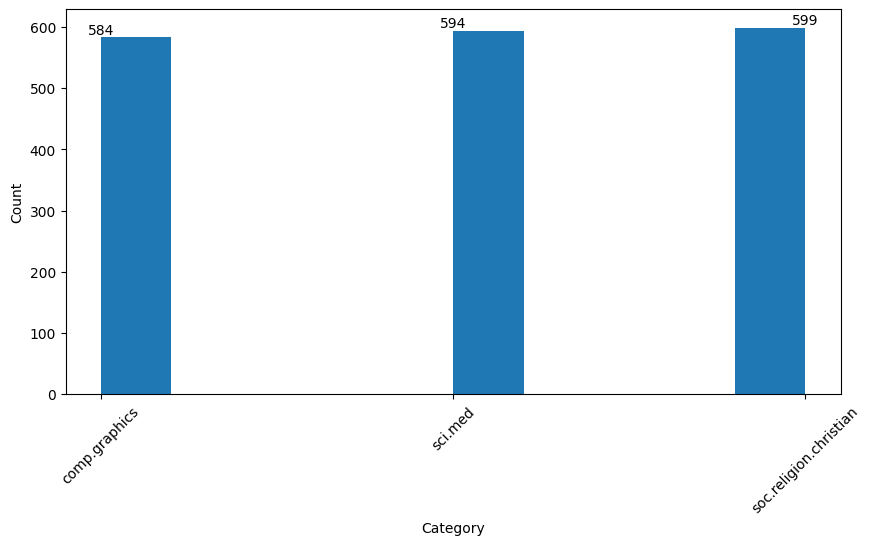

In [5]:
target_names_map = {i: name for i, name in enumerate(twenty_train.target_names)}

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(twenty_train.target)
ax.set_xticks(range(len(target_names_map)))
ax.set_xticklabels(target_names_map.values(), rotation=45)
# Add the count at the top of the bar
for i, count in enumerate(np.bincount(twenty_train.target)):
    ax.text(i, count, str(count), ha="center", va="bottom")
ax.set_xlabel("Category")
ax.set_ylabel("Count")
plt.show();

## Pipeline

In [6]:
pipeline_knn = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(stop_words="english", max_features=None, analyzer="word"),
        ),
        ("lsa", TruncatedSVD()),
        ("knn", KNNClassifier()),
    ]
)


pipeline_knn

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('lsa', TruncatedSVD()), ('knn', KNNClassifier())])

Grid search with cross-validation:

In [8]:
cv_knn = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=rs)

param_grid_knn = {
    "tfidf__max_features": [2048, 4096],
    "lsa": [TruncatedSVD(n_components=n) for n in [100, 150]]
    + ["passthrough"],  # Include 'passthrough' to test with or without LSA
    "knn__n_neighbors": [5, 10],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "cosine"],
}

grid_search_knn = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    scoring="accuracy",
    cv=cv_knn,
    n_jobs=-1,
    verbose=2,
    refit=True,
    error_score="raise",
)

grid_search_knn.fit(twenty_train.data, twenty_train.target)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


 78%|███████▊  | 276/356 [00:00<00:00, 328.60it/s]

[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, lsa=TruncatedSVD(n_components=100), tfidf__max_features=2048; total time=   3.7s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, lsa=TruncatedSVD(n_components=100), tfidf__max_features=2048; total time=   3.7s


 44%|████▍     | 157/356 [00:00<00:00, 283.68it/s]

[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, lsa=TruncatedSVD(n_components=100), tfidf__max_features=4096; total time=   3.9s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, lsa=TruncatedSVD(n_components=100), tfidf__max_features=4096; total time=   4.0s


 62%|██████▏   | 221/356 [00:00<00:00, 296.54it/s]

[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, lsa=TruncatedSVD(n_components=150), tfidf__max_features=2048; total time=   4.1s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, lsa=TruncatedSVD(n_components=150), tfidf__max_features=2048; total time=   4.2s


100%|██████████| 356/356 [00:01<00:00, 296.66it/s]


[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, lsa=TruncatedSVD(n_components=150), tfidf__max_features=4096; total time=   4.5s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, lsa=TruncatedSVD(n_components=150), tfidf__max_features=4096; total time=   4.6s


100%|██████████| 356/356 [00:01<00:00, 303.78it/s]


[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance, lsa=TruncatedSVD(n_components=100), tfidf__max_features=2048; total time=   3.8s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance, lsa=TruncatedSVD(n_components=100), tfidf__max_features=2048; total time=   3.8s


100%|██████████| 356/356 [00:01<00:00, 302.13it/s]
356it [00:02, 127.56it/s][00:00<00:00, 305.68it/s]


[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, lsa=passthrough, tfidf__max_features=2048; total time=   4.9s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, lsa=passthrough, tfidf__max_features=2048; total time=   4.9s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance, lsa=TruncatedSVD(n_components=100), tfidf__max_features=4096; total time=   4.2s


356it [00:02, 126.64it/s]
100%|██████████| 356/356 [00:01<00:00, 289.85it/s]
331it [00:02, 109.31it/s]

[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance, lsa=TruncatedSVD(n_components=100), tfidf__max_features=4096; total time=   4.0s


356it [00:03, 112.10it/s]
356it [00:03, 111.91it/s]


[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, lsa=passthrough, tfidf__max_features=4096; total time=   5.4s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, lsa=passthrough, tfidf__max_features=4096; total time=   5.3s


100%|██████████| 356/356 [00:01<00:00, 247.65it/s]


[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance, lsa=TruncatedSVD(n_components=150), tfidf__max_features=2048; total time=   4.5s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance, lsa=TruncatedSVD(n_components=150), tfidf__max_features=2048; total time=   4.5s


100%|██████████| 356/356 [00:01<00:00, 212.42it/s]
224it [00:02, 99.93it/s]]

[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance, lsa=TruncatedSVD(n_components=150), tfidf__max_features=4096; total time=   5.3s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance, lsa=TruncatedSVD(n_components=150), tfidf__max_features=4096; total time=   5.3s


356it [00:03, 102.95it/s]


[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance, lsa=passthrough, tfidf__max_features=2048; total time=   5.6s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance, lsa=passthrough, tfidf__max_features=2048; total time=   5.6s


356it [00:03, 103.75it/s]
356it [00:03, 93.11it/s] 
356it [00:03, 91.80it/s] 


[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance, lsa=passthrough, tfidf__max_features=4096; total time=   6.0s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance, lsa=passthrough, tfidf__max_features=4096; total time=   6.1s


100%|██████████| 356/356 [00:01<00:00, 326.06it/s]


[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform, lsa=TruncatedSVD(n_components=100), tfidf__max_features=2048; total time=   4.4s
[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform, lsa=TruncatedSVD(n_components=100), tfidf__max_features=2048; total time=   4.4s


 68%|██████▊   | 242/356 [00:00<00:00, 282.02it/s]

[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform, lsa=TruncatedSVD(n_components=100), tfidf__max_features=4096; total time=   4.3s
[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform, lsa=TruncatedSVD(n_components=100), tfidf__max_features=4096; total time=   4.3s


  0%|          | 0/356 [00:00<?, ?it/s]

[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform, lsa=TruncatedSVD(n_components=150), tfidf__max_features=2048; total time=   4.4s
[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform, lsa=TruncatedSVD(n_components=150), tfidf__max_features=2048; total time=   4.4s


100%|██████████| 356/356 [00:01<00:00, 260.01it/s]
142it [00:00, 138.66it/s]

[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform, lsa=TruncatedSVD(n_components=150), tfidf__max_features=4096; total time=   4.8s
[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform, lsa=TruncatedSVD(n_components=150), tfidf__max_features=4096; total time=   4.9s


356it [00:02, 120.48it/s]00:00<00:00, 319.64it/s]
356it [00:02, 133.98it/s]


[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform, lsa=passthrough, tfidf__max_features=2048; total time=   5.1s
[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform, lsa=passthrough, tfidf__max_features=2048; total time=   5.1s


100%|██████████| 356/356 [00:01<00:00, 278.54it/s]
265it [00:02, 111.70it/s]

[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=distance, lsa=TruncatedSVD(n_components=100), tfidf__max_features=2048; total time=   4.1s
[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=distance, lsa=TruncatedSVD(n_components=100), tfidf__max_features=2048; total time=   4.1s


356it [00:03, 108.59it/s][00:00<00:00, 337.75it/s]


[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform, lsa=passthrough, tfidf__max_features=4096; total time=   5.7s
[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform, lsa=passthrough, tfidf__max_features=4096; total time=   5.7s


356it [00:03, 108.31it/s][00:00<00:00, 354.07it/s]
100%|██████████| 356/356 [00:01<00:00, 323.00it/s]


[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=distance, lsa=TruncatedSVD(n_components=100), tfidf__max_features=4096; total time=   4.2s
[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=distance, lsa=TruncatedSVD(n_components=100), tfidf__max_features=4096; total time=   4.2s


100%|██████████| 356/356 [00:01<00:00, 222.20it/s]
55it [00:00, 138.22it/s][00:00<00:01, 310.70it/s]

[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=distance, lsa=TruncatedSVD(n_components=150), tfidf__max_features=2048; total time=   4.8s
[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=distance, lsa=TruncatedSVD(n_components=150), tfidf__max_features=2048; total time=   4.8s


100%|██████████| 356/356 [00:01<00:00, 260.27it/s]


[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=distance, lsa=TruncatedSVD(n_components=150), tfidf__max_features=4096; total time=   5.2s
[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=distance, lsa=TruncatedSVD(n_components=150), tfidf__max_features=4096; total time=   5.2s


100%|██████████| 356/356 [00:01<00:00, 260.09it/s]
356it [00:02, 122.55it/s]
240it [00:02, 104.27it/s]

[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=distance, lsa=passthrough, tfidf__max_features=2048; total time=   5.4s
[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=distance, lsa=passthrough, tfidf__max_features=2048; total time=   5.5s


356it [00:02, 120.50it/s]
356it [00:03, 101.42it/s][00:00<00:01, 191.93it/s]
355it [00:03, 103.75it/s]

[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=distance, lsa=passthrough, tfidf__max_features=4096; total time=   6.0s
[CV] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=distance, lsa=passthrough, tfidf__max_features=4096; total time=   6.0s


356it [00:03, 101.95it/s][00:00<00:01, 181.23it/s]
 16%|█▌        | 57/356 [00:00<00:01, 171.61it/s]

[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=uniform, lsa=TruncatedSVD(n_components=100), tfidf__max_features=2048; total time=   4.9s
[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=uniform, lsa=TruncatedSVD(n_components=100), tfidf__max_features=2048; total time=   4.9s


 31%|███       | 111/356 [00:00<00:02, 120.05it/s]

[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=uniform, lsa=TruncatedSVD(n_components=100), tfidf__max_features=4096; total time=   5.4s


 39%|███▉      | 138/356 [00:01<00:02, 99.65it/s] 

[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=uniform, lsa=TruncatedSVD(n_components=100), tfidf__max_features=4096; total time=   5.5s


 36%|███▌      | 127/356 [00:00<00:01, 153.25it/s]

[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=uniform, lsa=TruncatedSVD(n_components=150), tfidf__max_features=2048; total time=   6.0s
[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=uniform, lsa=TruncatedSVD(n_components=150), tfidf__max_features=2048; total time=   6.1s


100%|██████████| 356/356 [00:02<00:00, 149.38it/s]
240it [00:02, 104.30it/s][00:02<00:00, 152.03it/s]

[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=uniform, lsa=TruncatedSVD(n_components=150), tfidf__max_features=4096; total time=   6.5s


100%|██████████| 356/356 [00:02<00:00, 132.61it/s]


[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=uniform, lsa=TruncatedSVD(n_components=150), tfidf__max_features=4096; total time=   6.7s


356it [00:04, 87.03it/s] 
356it [00:04, 87.52it/s]
186it [00:02, 78.06it/s]00:00<?, ?it/s]

[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=uniform, lsa=passthrough, tfidf__max_features=2048; total time=   6.7s
[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=uniform, lsa=passthrough, tfidf__max_features=2048; total time=   6.7s


100%|██████████| 356/356 [00:02<00:00, 149.94it/s]
346it [00:04, 72.51it/s] [00:02<00:00, 161.09it/s]

[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=distance, lsa=TruncatedSVD(n_components=100), tfidf__max_features=2048; total time=   5.5s


100%|██████████| 356/356 [00:02<00:00, 145.74it/s]


[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=distance, lsa=TruncatedSVD(n_components=100), tfidf__max_features=2048; total time=   5.6s
[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=uniform, lsa=passthrough, tfidf__max_features=4096; total time=   7.6s
[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=uniform, lsa=passthrough, tfidf__max_features=4096; total time=   7.4s


356it [00:05, 71.09it/s]00:00<00:04, 79.56it/s]s]
356it [00:04, 71.73it/s]
 27%|██▋       | 96/356 [00:00<00:01, 150.13it/s]]

[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=distance, lsa=TruncatedSVD(n_components=100), tfidf__max_features=4096; total time=   6.0s


 46%|████▌     | 164/356 [00:01<00:01, 151.19it/s]

[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=distance, lsa=TruncatedSVD(n_components=100), tfidf__max_features=4096; total time=   6.0s


100%|██████████| 356/356 [00:02<00:00, 135.69it/s]
103it [00:01, 84.23it/s]

[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=distance, lsa=TruncatedSVD(n_components=150), tfidf__max_features=2048; total time=   6.4s
[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=distance, lsa=TruncatedSVD(n_components=150), tfidf__max_features=2048; total time=   6.5s


100%|██████████| 356/356 [00:02<00:00, 149.92it/s]
151it [00:01, 84.59it/s]

[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=distance, lsa=TruncatedSVD(n_components=150), tfidf__max_features=4096; total time=   6.7s


356it [00:04, 84.22it/s] [00:02<00:00, 139.81it/s]


[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=distance, lsa=passthrough, tfidf__max_features=2048; total time=   6.7s
[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=distance, lsa=passthrough, tfidf__max_features=2048; total time=   6.8s


356it [00:04, 81.96it/s] [00:02<00:00, 84.00it/s] 
100%|██████████| 356/356 [00:02<00:00, 126.80it/s]


[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=distance, lsa=TruncatedSVD(n_components=150), tfidf__max_features=4096; total time=   7.0s


100%|██████████| 356/356 [00:01<00:00, 189.84it/s]
356it [00:04, 79.17it/s]
347it [00:04, 86.63it/s]

[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=uniform, lsa=TruncatedSVD(n_components=100), tfidf__max_features=2048; total time=   5.0s
[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=uniform, lsa=TruncatedSVD(n_components=100), tfidf__max_features=2048; total time=   5.0s
[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=distance, lsa=passthrough, tfidf__max_features=4096; total time=   7.1s


356it [00:04, 80.22it/s]


[CV] END knn__metric=cosine, knn__n_neighbors=5, knn__weights=distance, lsa=passthrough, tfidf__max_features=4096; total time=   7.0s


 71%|███████▏  | 254/356 [00:01<00:00, 160.16it/s]

[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=uniform, lsa=TruncatedSVD(n_components=100), tfidf__max_features=4096; total time=   5.2s
[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=uniform, lsa=TruncatedSVD(n_components=100), tfidf__max_features=4096; total time=   5.0s


100%|██████████| 356/356 [00:02<00:00, 141.94it/s]


[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=uniform, lsa=TruncatedSVD(n_components=150), tfidf__max_features=2048; total time=   5.6s
[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=uniform, lsa=TruncatedSVD(n_components=150), tfidf__max_features=2048; total time=   5.6s


100%|██████████| 356/356 [00:02<00:00, 150.99it/s]


[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=uniform, lsa=TruncatedSVD(n_components=150), tfidf__max_features=4096; total time=   6.2s
[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=uniform, lsa=passthrough, tfidf__max_features=2048; total time=   6.3s


356it [00:04, 86.12it/s] [00:02<00:00, 138.64it/s]
100%|██████████| 356/356 [00:02<00:00, 132.28it/s]
356it [00:04, 86.16it/s]
84it [00:01, 84.17it/s]

[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=uniform, lsa=TruncatedSVD(n_components=150), tfidf__max_features=4096; total time=   6.5s
[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=uniform, lsa=passthrough, tfidf__max_features=2048; total time=   6.3s


 97%|█████████▋| 345/356 [00:01<00:00, 191.75it/s]

[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=distance, lsa=TruncatedSVD(n_components=100), tfidf__max_features=2048; total time=   4.9s
[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=distance, lsa=TruncatedSVD(n_components=100), tfidf__max_features=2048; total time=   4.9s


100%|██████████| 356/356 [00:01<00:00, 191.45it/s]
356it [00:04, 84.31it/s][00:00<00:01, 216.80it/s]
346it [00:04, 84.88it/s][00:00<00:01, 171.72it/s]

[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=uniform, lsa=passthrough, tfidf__max_features=4096; total time=   6.8s


356it [00:04, 84.16it/s][00:00<00:01, 164.17it/s]
 25%|██▌       | 90/356 [00:00<00:01, 170.37it/s]

[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=uniform, lsa=passthrough, tfidf__max_features=4096; total time=   6.9s


 73%|███████▎  | 259/356 [00:02<00:00, 159.12it/s]

[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=distance, lsa=TruncatedSVD(n_components=100), tfidf__max_features=4096; total time=   5.5s
[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=distance, lsa=TruncatedSVD(n_components=100), tfidf__max_features=4096; total time=   5.5s


100%|██████████| 356/356 [00:02<00:00, 130.23it/s]



[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=distance, lsa=TruncatedSVD(n_components=150), tfidf__max_features=2048; total time=   5.9s[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=distance, lsa=TruncatedSVD(n_components=150), tfidf__max_features=2048; total time=   5.9s



100%|██████████| 356/356 [00:02<00:00, 176.95it/s]


[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=distance, lsa=TruncatedSVD(n_components=150), tfidf__max_features=4096; total time=   6.1s
[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=distance, lsa=TruncatedSVD(n_components=150), tfidf__max_features=4096; total time=   6.0s


100%|██████████| 356/356 [00:02<00:00, 177.30it/s]
356it [00:02, 122.45it/s]
356it [00:02, 127.47it/s]


[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=distance, lsa=passthrough, tfidf__max_features=2048; total time=   5.6s
[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=distance, lsa=passthrough, tfidf__max_features=2048; total time=   5.4s


356it [00:02, 134.20it/s]
356it [00:02, 136.87it/s]


[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=distance, lsa=passthrough, tfidf__max_features=4096; total time=   4.6s
[CV] END knn__metric=cosine, knn__n_neighbors=10, knn__weights=distance, lsa=passthrough, tfidf__max_features=4096; total time=   4.4s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=2,
            random_state=RandomState(MT19937) at 0x134364440,
            test_size=0.2, train_size=None),
             error_score='raise',
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('lsa', TruncatedSVD()),
                                       ('knn', KNNClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'cosine'],
                         'knn__n_neighbors': [5, 10],
                         'knn__weights': ['uniform', 'distance'],
                         'lsa': [TruncatedSVD(n_components=100),
                                 TruncatedSVD(n_components=150),
                                 'passthrough'],
                         'tfidf__max_features': [2048, 4096]},
             scoring='accuracy', verbose=2)

In [11]:
pd.DataFrame(grid_search_knn.cv_results_).sort_values("rank_test_score").head(15)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__weights,param_lsa,param_tfidf__max_features,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
47,1.606847,0.072912,2.902957,0.017791,cosine,10,distance,passthrough,4096,"{'knn__metric': 'cosine', 'knn__n_neighbors': ...",0.943820,0.957865,0.950843,0.007022,1
23,2.181849,0.022403,3.858796,0.029430,euclidean,10,distance,passthrough,4096,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.941011,0.957865,0.949438,0.008427,2
41,2.254243,0.007904,4.607221,0.004900,cosine,10,uniform,passthrough,4096,"{'knn__metric': 'cosine', 'knn__n_neighbors': ...",0.932584,0.955056,0.943820,0.011236,3
17,1.968997,0.010930,3.717431,0.022824,euclidean,10,uniform,passthrough,4096,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.932584,0.955056,0.943820,0.011236,3
45,3.643066,0.044459,2.384880,0.016174,cosine,10,distance,TruncatedSVD(n_components=150),4096,"{'knn__metric': 'cosine', 'knn__n_neighbors': ...",0.938202,0.946629,0.942416,0.004213,5
46,2.246714,0.018586,3.259752,0.045393,cosine,10,distance,passthrough,2048,"{'knn__metric': 'cosine', 'knn__n_neighbors': ...",0.938202,0.946629,0.942416,0.004213,5
22,1.905321,0.004269,3.558972,0.038876,euclidean,10,distance,passthrough,2048,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.935393,0.946629,0.941011,0.005618,7
40,1.801245,0.028401,4.484627,0.018367,cosine,10,uniform,passthrough,2048,"{'knn__metric': 'cosine', 'knn__n_neighbors': ...",0.935393,0.943820,0.939607,0.004213,8
35,2.145196,0.004792,4.891026,0.047543,cosine,5,distance,passthrough,4096,"{'knn__metric': 'cosine', 'knn__n_neighbors': ...",0.932584,0.946629,0.939607,0.007022,8
16,1.787896,0.012508,3.282829,0.008110,euclidean,10,uniform,passthrough,2048,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.935393,0.943820,0.939607,0.004213,8


## Prediction

In [13]:
twenty_test = fetch_20newsgroups(
    subset="test", categories=categories, shuffle=True, random_state=rs
)

test_data = twenty_test.data

predicted_targets = grid_search_knn.predict(test_data)

predicted_targets

array([1, 0, 2, ..., 2, 2, 0])

In [15]:
classification_reports = classification_report(
    y_true=twenty_test.target,
    y_pred=predicted_targets,
    target_names=target_names_map.values(),
    output_dict=True,
)

classification_reports_df = pd.DataFrame(classification_reports).T

classification_reports_df

,precision,recall,f1-score,support
comp.graphics,0.856459,0.920308,0.887237,389.000000
sci.med,0.914040,0.805556,0.856376,396.000000
soc.religion.christian,0.887019,0.927136,0.906634,398.000000
accuracy,0.884193,0.884193,0.884193,0.884193
macro avg,0.885840,0.884333,0.883415,1183.000000
weighted avg,0.886015,0.884193,0.883432,1183.000000


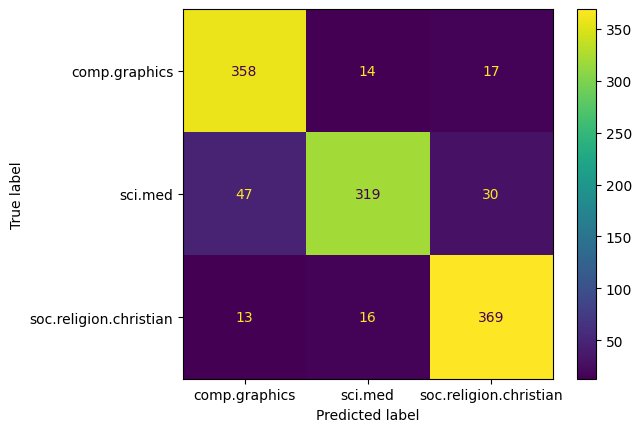

In [22]:
ConfusionMatrixDisplay.from_predictions(
    y_true=twenty_test.target,
    y_pred=predicted_targets,
    display_labels=target_names_map.values(),
)

## Sci-kit Learn Implementation

In [23]:
pipeline_knn_sklearn = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(stop_words="english", max_features=None, analyzer="word"),
        ),
        ("knn", KNeighborsClassifier()),
    ]
)

param_grid_knn_sklearn = {
    "tfidf__max_features": [2048, 4096],
    "knn__n_neighbors": [5, 10],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "cosine"],
}

grid_search_knn_sklearn = GridSearchCV(
    estimator=pipeline_knn_sklearn,
    param_grid=param_grid_knn_sklearn,
    scoring="accuracy",
    cv=cv_knn,
    n_jobs=-1,
    verbose=2,
    refit=True,
    error_score="raise",
)

grid_search_knn_sklearn.fit(twenty_train.data, twenty_train.target)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, tfidf__max_features=2048; total time=   3.9s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, tfidf__max_features=2048; total time=   4.1s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, tfidf__max_features=4096; total time=   4.2s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, tfidf__max_features=4096; total time=   4.3s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance, tfidf__max_features=2048; total time=   4.3s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance, tfidf__max_features=2048; total time=   4.3s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance, tfidf__max_features=4096; total time=   4.4s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance, tfidf__max_features=4096; to

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=2,
            random_state=RandomState(MT19937) at 0x134364440,
            test_size=0.2, train_size=None),
             error_score='raise',
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'cosine'],
                         'knn__n_neighbors': [5, 10],
                         'knn__weights': ['uniform', 'distance'],
                         'tfidf__max_features': [2048, 4096]},
             scoring='accuracy', verbose=2)

In [24]:
pd.DataFrame(grid_search_knn_sklearn.cv_results_).sort_values("rank_test_score").head(
    15
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__weights,param_tfidf__max_features,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
15,2.280916,0.054798,0.578183,0.013260,cosine,10,distance,4096,"{'knn__metric': 'cosine', 'knn__n_neighbors': ...",0.949438,0.957865,0.953652,0.004213,1
14,2.303143,0.024792,0.600492,0.016114,cosine,10,distance,2048,"{'knn__metric': 'cosine', 'knn__n_neighbors': ...",0.949438,0.952247,0.950843,0.001404,2
7,2.945369,0.019870,0.713333,0.016232,euclidean,10,distance,4096,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.943820,0.957865,0.950843,0.007022,3
6,2.939650,0.018075,0.688899,0.015188,euclidean,10,distance,2048,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.946629,0.952247,0.949438,0.002809,4
5,2.838412,0.003440,0.813033,0.024758,euclidean,10,uniform,4096,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.943820,0.952247,0.948034,0.004213,5
13,2.294118,0.081125,0.686162,0.035491,cosine,10,uniform,4096,"{'knn__metric': 'cosine', 'knn__n_neighbors': ...",0.943820,0.952247,0.948034,0.004213,5
11,1.749632,0.032664,0.485172,0.014497,cosine,5,distance,4096,"{'knn__metric': 'cosine', 'knn__n_neighbors': ...",0.938202,0.946629,0.942416,0.004213,7
4,3.035304,0.152324,0.797720,0.053641,euclidean,10,uniform,2048,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.943820,0.938202,0.941011,0.002809,8
12,2.259145,0.014400,0.681822,0.065765,cosine,10,uniform,2048,"{'knn__metric': 'cosine', 'knn__n_neighbors': ...",0.943820,0.938202,0.941011,0.002809,8
1,3.215376,0.006481,1.045322,0.042073,euclidean,5,uniform,4096,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.932584,0.946629,0.939607,0.007022,10


In [25]:
predicted_targets_sklearn = grid_search_knn_sklearn.predict(test_data)

classification_reports_sklearn = classification_report(
    y_true=twenty_test.target,
    y_pred=predicted_targets_sklearn,
    target_names=target_names_map.values(),
    output_dict=True,
)

classification_reports_sklearn_df = pd.DataFrame(classification_reports_sklearn).T

classification_reports_sklearn_df

,precision,recall,f1-score,support
comp.graphics,0.856459,0.920308,0.887237,389.000000
sci.med,0.914040,0.805556,0.856376,396.000000
soc.religion.christian,0.887019,0.927136,0.906634,398.000000
accuracy,0.884193,0.884193,0.884193,0.884193
macro avg,0.885840,0.884333,0.883415,1183.000000
weighted avg,0.886015,0.884193,0.883432,1183.000000


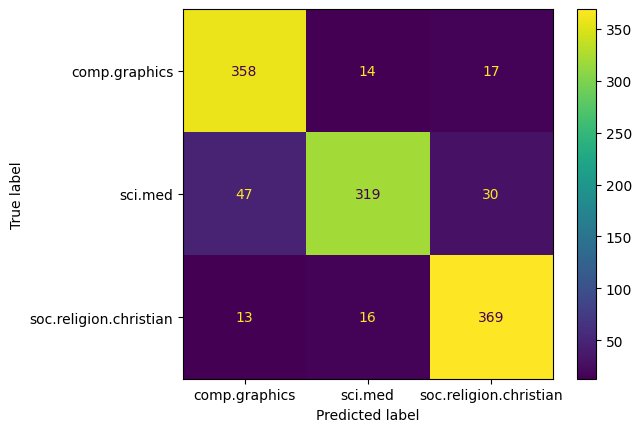

In [26]:
ConfusionMatrixDisplay.from_predictions(
    y_true=twenty_test.target,
    y_pred=predicted_targets_sklearn,
    display_labels=target_names_map.values(),
)